## Examples using GradientBoostedLowess

### Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import torch

from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from GradientBoostedLowess import GradientBoostedLowess

# Evaluating the model
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error as mse

# Data visualization
import matplotlib.pyplot as plt

In [2]:
seed = 441

### Applying GradientBoostedLowess on Data with 1 Feature

In [21]:
# Simulate data
def true_model(X):
    return 4*np.sin(X) + 5

sample_size = 1000
np.random.seed(seed)

noise = np.random.normal(size=sample_size)
X = torch.Tensor(np.random.uniform(-15, 15, sample_size))
y = torch.Tensor(true_model(X) + noise)

(X.shape, y.shape)

(torch.Size([1000]), torch.Size([1000]))

In [29]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=seed)

scaler = StandardScaler()
Xtrain_scaled = torch.Tensor(scaler.fit_transform(Xtrain.reshape(-1,1)))
Xtest_scaled = torch.Tensor(scaler.transform(Xtest.reshape(-1,1)))

model = GradientBoostedLowess(learning_rate=0.01, n_estimators=10, max_depth=10)
model.fit(Xtrain_scaled, ytrain)

y_pred = model.predict(Xtest_scaled)
print("Mean squared error of predictions:", mse(ytest, y_pred))

Mean squared error of predictions: 1.6128355403380765


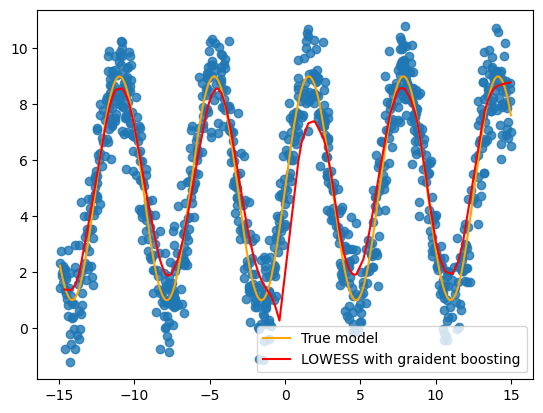

In [30]:
plt.scatter(X, y, alpha=0.8)

sort_idx = X.argsort()
plt.plot(X[sort_idx], true_model(X)[sort_idx], color='orange', label='True model')

sort_idx = Xtest.argsort()
plt.plot(Xtest[sort_idx], y_pred[sort_idx], color='red', label='LOWESS with graident boosting')

plt.legend(loc='lower right')
plt.show()

### Testing GradientBoostedLowess with Different Scalers on Data with 3 Features

In [7]:
data = pd.read_csv("../../data/cars.csv")
data

,MPG,CYL,ENG,WGT
0,18.0,8,307.0,3504
1,15.0,8,350.0,3693
2,18.0,8,318.0,3436
3,16.0,8,304.0,3433
4,17.0,8,302.0,3449
...,...,...,...,...
387,27.0,4,140.0,2790
388,44.0,4,97.0,2130
389,32.0,4,135.0,2295
390,28.0,4,120.0,2625


In [8]:
X = torch.Tensor(data.drop('MPG', axis=1).values)
y = torch.Tensor(data['MPG'].values)

(X.shape, y.shape)

(torch.Size([392, 3]), torch.Size([392]))

In [9]:
def DoKFold(X, y, model=GradientBoostedLowess(), scaler=StandardScaler()):
    '''Perform k-fold validation'''
    train_mse = []
    test_mse = []

    kf = KFold(n_splits=10)
    for idxTrain, idxTest in kf.split(X, y):
        Xtrain = X[idxTrain]
        Xtest = X[idxTest]
        ytrain = y[idxTrain]
        ytest = y[idxTest]

        Xtrain_scaled = torch.Tensor(scaler.fit_transform(Xtrain))
        Xtest_scaled = torch.Tensor(scaler.transform(Xtest))

        model.fit(Xtrain_scaled, ytrain)

        train_mse.append(mse(ytrain, model.predict(Xtrain_scaled)))
        test_mse.append(mse(ytest, model.predict(Xtest_scaled)))

    print("Average training mean squared error:", np.mean(train_mse))
    print("Average testing mean squared error:", np.mean(test_mse))

In [11]:
DoKFold(X, y, GradientBoostedLowess(n_estimators=3, min_samples_split=50, max_depth=3), StandardScaler())

Average training mean squared error: 8.238272
Average testing mean squared error: 91.448975


In [12]:
DoKFold(X, y, GradientBoostedLowess(n_estimators=3), MinMaxScaler())

Average training mean squared error: 13.716249
Average testing mean squared error: 27.24888


In [10]:
DoKFold(X, y, GradientBoostedLowess(n_estimators=3), QuantileTransformer(n_quantiles=70))

Average training mean squared error: 12.770006
Average testing mean squared error: 20.142933
